In [1]:
from packages import *

In [2]:
#### GET the SPIN UP FILES

input_path = '/bsuhome/stanleyakor/scratch/thompson/'
input_file = 'thompson_spinup2_sliced.nc'
in_var_name = 'SNOW'
out_var_name = 'SNOW'
operator = 'mean'
description = 'Mean daily snow height'
units = 'mm'
rain_bucket_vol = 100

accumulated_SWE_thompson = hourly_to_daily(input_path, input_file, in_var_name,\
                                              out_var_name, operator, description, units, rain_bucket_vol)




input_path = '/bsuhome/stanleyakor/scratch/wsm6/'
input_file = 'wsm6_spinup2_sliced.nc'
in_var_name = 'SNOW'
out_var_name = 'SNOW'
operator = 'mean'
description = 'Mean daily snow height'
units = 'mm'
rain_bucket_vol = 100


accumulated_SWE_wsm6 = hourly_to_daily(input_path, input_file, in_var_name,\
                                             out_var_name, operator, description, units, rain_bucket_vol)






In [3]:
#SNODAS SWE

path3 = '/bsuhome/stanleyakor/scratch/NOHRSC_SNODAS/download_data/nc/SWE_snodas_2023*'
ds_snodas=xr.open_mfdataset(path3, combine='nested', concat_dim='time', parallel=True)
ds_snodas= ds_snodas.swap_dims({'time': 'XTIME'})
ds_snodas = ds_snodas['SWE']

## REGRID SNODAS TO WRF RES

In [4]:
grid_template = xr.open_dataset(input_path+input_file)

In [5]:
LAT = grid_template.variables['XLAT'][0].copy()
LON =grid_template.variables['XLONG'][0].copy()

In [6]:

target_grid = xr.Dataset({
    'lat': LAT,
    'lon': LON
})

# Create xESMF regridder using the target grid
regridder = xe.Regridder(ds_snodas, target_grid, 'bilinear')

# Perform regridding
ds_snodas_regridded = regridder(ds_snodas)

## PLOT SWE FOR MARCH 1

In [7]:
thomson_swe_march1 = accumulated_SWE_thompson['SNOW'].isel(XTIME=59)
snodas_swe_march1 = ds_snodas_regridded.isel(XTIME = 59)
wsm6_swe_march1 = accumulated_SWE_wsm6['SNOW'].isel(XTIME=59)

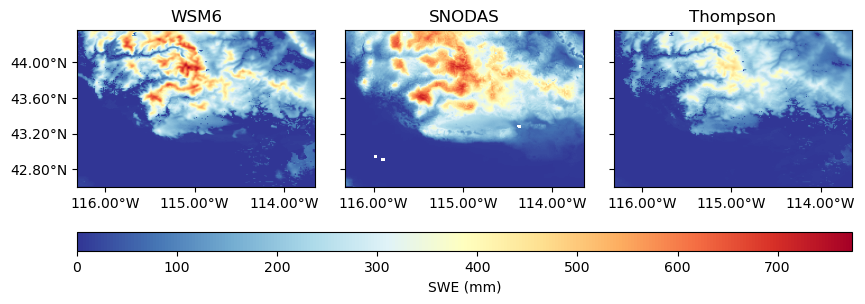

In [8]:
lon = LON #snodas_swh_march1
lat = LAT
file_list = [wsm6_swe_march1,snodas_swe_march1,  thomson_swe_march1]
title = ['WSM6', 'SNODAS', 'Thompson'] #

make_snodas_Wrf_plots(file_list, title, lat, lon, 'SWE_MARCH1',\
                      'SWE (mm)',colour='RdYlBu_r')

## SEE HOW THEY DIFFER

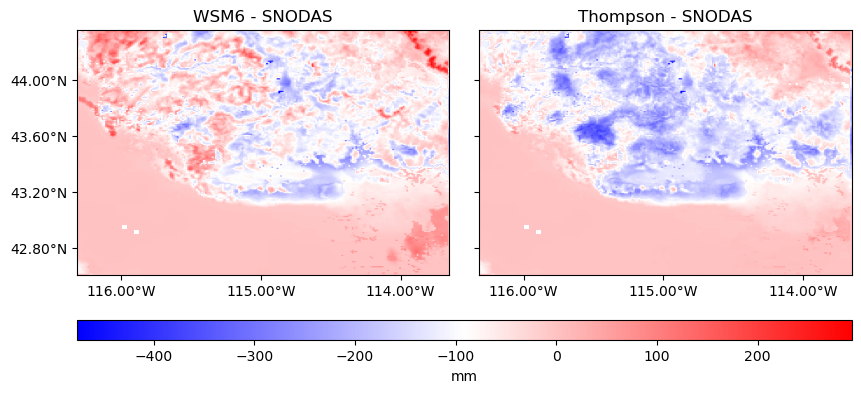

In [9]:

file_list = [wsm6_swe_march1-snodas_swe_march1, thomson_swe_march1-snodas_swe_march1]
title = ['WSM6 - SNODAS','Thompson - SNODAS']

make_snodas_Wrf_plots(file_list, title, lat, lon, 'SWE_DIFF_MARCH1',\
                      'mm',subplots=(1,2),colour='bwr')

## Make Plot of Snotel sites in Idaho

In [10]:
# read in the NRCS_snotel sites

In [11]:
SNOTEL_info = pd.read_csv('./NRCS_SNOTEL_Locations_noAlaska.csv')

In [12]:
StartDate = '2022'
EndDate = '2023'
State = 'ID'
Names = list(SNOTEL_info[SNOTEL_info['State']==State]['Station Name'].values)
IDs = list(SNOTEL_info[SNOTEL_info['State']==State]['Station ID'].values)
Lat = list(SNOTEL_info[SNOTEL_info['State'] ==State]['Latitude'].values)
Lon = list(SNOTEL_info[SNOTEL_info['State'] ==State]['Longitude'].values)

In [13]:
wrf_lat_min = LAT.min()
wrf_lat_max = LAT.max()

wrf_lon_min = LON.min()
wrf_lon_max = LON.max()

In [14]:
Required_sites_lat = []
Required_sites_lon = []
Required_sites_name = []
for x,y,z in zip(Lat,Lon,Names):
    if ( (wrf_lat_min <=x<= wrf_lat_max) & (wrf_lon_min <=y<= wrf_lon_max)):
        Required_sites_lat.append(x)
        Required_sites_lon.append(y)
        Required_sites_name.append(z)
        
        

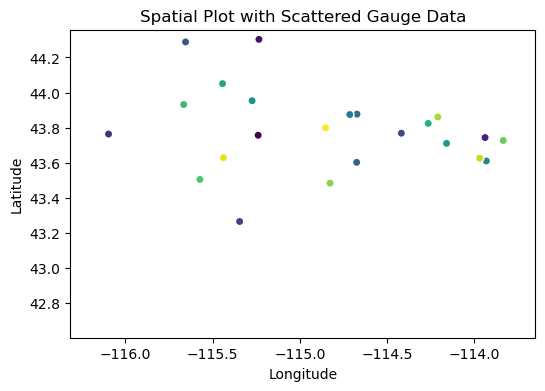

In [15]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Sample gauge data with latitude and longitude
gauge_data = {
    'latitude': Required_sites_lat,
    'longitude': Required_sites_lon,
    'value': np.arange(0,23)
}

# Create a 2D grid with NaN values
lon_range = np.arange(wrf_lon_min , wrf_lon_max , 0.001)
lat_range = np.arange(wrf_lat_min ,wrf_lat_max, 0.001)
lon, lat = np.meshgrid(lon_range, lat_range)
grid_data = np.full_like(lon, np.nan)

# Place the gauge data on the grid using latitude and longitude coordinates
for lat_gauge, lon_gauge, value in zip(gauge_data['latitude'], gauge_data['longitude'], gauge_data['value']):
    lat_idx = np.argmin(np.abs(lat_range - lat_gauge))
    lon_idx = np.argmin(np.abs(lon_range - lon_gauge))
    grid_data[lat_idx, lon_idx] = value

# Convert the grid_data to an xarray DataArray
da_grid = xr.DataArray(grid_data, coords=[('latitude', lat_range), ('longitude', lon_range)])

# Create a spatial plot using matplotlib
plt.figure(figsize=(6,4 ))
plt.imshow(da_grid, extent=[lon_range.min(), lon_range.max(), lat_range.min(), lat_range.max()],
           origin='lower', cmap='viridis', aspect='auto',alpha=0)
#plt.colorbar(label='Gauge Data Value')
plt.scatter(gauge_data['longitude'], gauge_data['latitude'], c=gauge_data['value'], cmap='viridis', edgecolors='w')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial Plot with Scattered Gauge Data')
plt.show()


## SNOW HEIGHT

In [16]:
#### GET the SPIN UP FILES

input_path = '/bsuhome/stanleyakor/scratch/thompson/'
input_file = 'thompson_spinup2_sliced.nc'
in_var_name = 'SNOWH'
out_var_name = 'SNOWH'
operator = 'mean'
description = 'Mean daily snow height'
units = 'm'
rain_bucket_vol = 100

accumulated_SWH_thompson = hourly_to_daily(input_path, input_file, in_var_name,\
                                              out_var_name, operator, description, units, rain_bucket_vol)




input_path = '/bsuhome/stanleyakor/scratch/wsm6/'
input_file = 'wsm6_spinup2_sliced.nc'
in_var_name = 'SNOWH'
out_var_name = 'SNOWH'
operator = 'mean'
description = 'Mean daily snow height'
units = 'm'
rain_bucket_vol = 100


accumulated_SWH_wsm6 = hourly_to_daily(input_path, input_file, in_var_name,\
                                             out_var_name, operator, description, units, rain_bucket_vol)






In [17]:
#SNODA SWE

path3 = '/bsuhome/stanleyakor/scratch/NOHRSC_SNODAS/download_data/nc/SNWZ_snodas_2023*'
ds_snodas=xr.open_mfdataset(path3, combine='nested', concat_dim='time', parallel=True)
ds_snodas= ds_snodas.swap_dims({'time': 'XTIME'})

In [18]:
ds_snodas = ds_snodas['SNWZ']
# Create xESMF regridder using the target grid
regridder = xe.Regridder(ds_snodas, target_grid, 'bilinear')

# Perform regridding
ds_snodas_regridded = regridder(ds_snodas)

In [19]:
thomson_swh_march1 = accumulated_SWH_thompson['SNOWH'].isel(XTIME=59)
snodas_swh_march1 = ds_snodas_regridded.isel(XTIME = 59)*1e-3
wsm6_swh_march1 = accumulated_SWH_wsm6['SNOWH'].isel(XTIME=59)

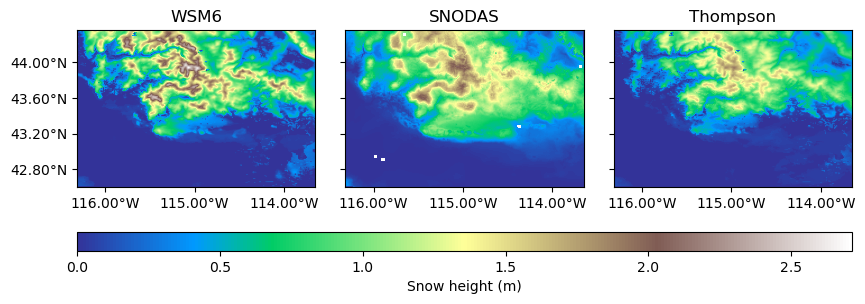

In [20]:

file_list = [wsm6_swh_march1,snodas_swh_march1,  thomson_swh_march1]
title = ['WSM6', 'SNODAS', 'Thompson'] #


make_snodas_Wrf_plots(file_list, title, lat, lon, 'SWH_MARCH1',\
                      'Snow height (m)',colour='terrain')

## Difference in Snow depth

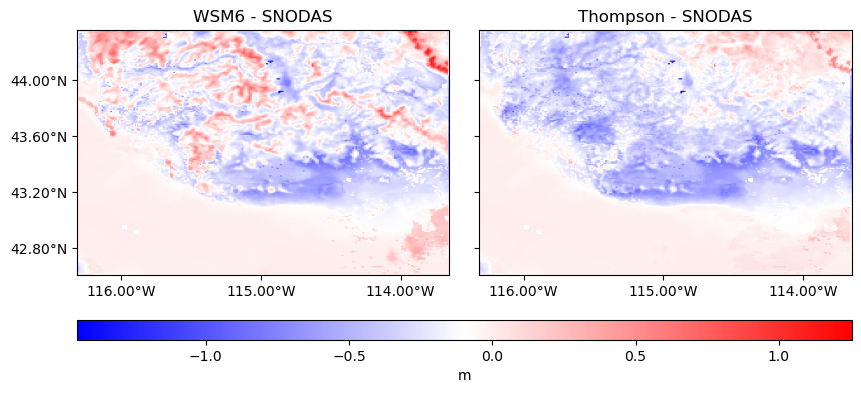

In [27]:
file_list = [wsm6_swh_march1 - snodas_swh_march1,thomson_swh_march1 - snodas_swh_march1]
title = ['WSM6 - SNODAS','Thompson - SNODAS'] #


make_snodas_Wrf_plots(file_list, title, lat, lon, 'SWH_DIFF_MARCH1',\
                      'm',subplots=(1,2),colour='bwr')